In [2]:
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc,confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
import cv2
import matplotlib.pyplot as plt

In [3]:
seed = 42
np.random.seed(seed)

# ruta = C:/Users/benja/Desktop/ia/proyecto1-ia/dataset
ruta = "C:/Users/pablo/OneDrive/Documentos/UCT/GitHub/proyecto1-ia/dataset"

# Lista de imágenes excluyendo las que son máscaras
imagen_path = sorted([p for p in glob.glob(ruta + "/*.jpg") if "_expert" not in p])

# Partición de datos por imagen
entrenamiento_val, test = train_test_split(imagen_path, test_size=0.2, random_state=seed)
entrenamiento, val = train_test_split(entrenamiento_val, test_size=0.25, random_state=seed)
print("Entrenamiento:", len(entrenamiento), "Validación:", len(val), "Test:", len(test))

def carga_imagen(paths):
    imagenes, mascaras = [], []
    for imagen_path in paths:
        img = cv2.cvtColor(cv2.imread(imagen_path), cv2.COLOR_BGR2RGB)
        mask_path = imagen_path.replace('.jpg', '_expert.png')
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Advertencia: No se encontró la máscara para {mask_path}")
            continue
        mask = (mask > 0).astype(np.uint8)  # Binaria
        imagenes.append(img)
        mascaras.append(mask)
    return imagenes, mascaras

train_images, train_masks = carga_imagen(entrenamiento)
val_images, val_masks = carga_imagen(val)
test_images, test_masks = carga_imagen(test)

def normalize(images):
    return [img.astype(np.float32) / 255.0 for img in images]  # Conversión explícita

train_images = normalize(train_images)
val_images = normalize(val_images)
test_images = normalize(test_images)

# Corrección de iluminación (opcional)
def corregir_iluminacion(img):
    # Convertir a uint8 para CLAHE si está normalizada
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    result = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return result.astype(np.float32) / 255.0  # Normalizar de vuelta

# Muestreo equilibrado CORREGIDO
def muestreo_equilibrado(imagenes, mascaras, n=10000):
    lesion_pixels = []
    no_lesion_pixels = []
    
    for img, mask in zip(imagenes, mascaras):
        # Extraer coordenadas donde mask == 1 y mask == 0
        lesion_coords = np.where(mask == 1)
        no_lesion_coords = np.where(mask == 0)
        
        # Extraer píxeles RGB usando las coordenadas
        lesion_rgb = img[lesion_coords]  # Shape: (n_lesion_pixels, 3)
        no_lesion_rgb = img[no_lesion_coords]  # Shape: (n_no_lesion_pixels, 3)
        
        lesion_pixels.extend(lesion_rgb)
        no_lesion_pixels.extend(no_lesion_rgb)
    
    # Convertir a arrays numpy
    lesion_pixels = np.array(lesion_pixels)
    no_lesion_pixels = np.array(no_lesion_pixels)
    
    # Muestreo aleatorio equilibrado
    n_per_class = min(n//2, len(lesion_pixels), len(no_lesion_pixels))
    
    lesion_indices = np.random.choice(len(lesion_pixels), n_per_class, replace=False)
    no_lesion_indices = np.random.choice(len(no_lesion_pixels), n_per_class, replace=False)
    
    # Crear dataset final
    X = np.vstack([lesion_pixels[lesion_indices], no_lesion_pixels[no_lesion_indices]])
    y = np.hstack([np.ones(n_per_class), np.zeros(n_per_class)])
    
    # Mezclar los datos
    shuffle_indices = np.random.permutation(len(X))
    return X[shuffle_indices], y[shuffle_indices]

# Procesar datos de entrenamiento, validación y test
X_entrenamiento, y_entrenamiento = muestreo_equilibrado(train_images, train_masks, n=10000)
X_validacion, y_validacion = muestreo_equilibrado(val_images, val_masks, n=5000)

print("✓ Datos cargados, particionados y preprocesados correctamente")
print(f"Entrenamiento: {X_entrenamiento.shape[0]} píxeles")
print(f"Validación: {X_validacion.shape[0]} píxeles")
print(f"Test: {len(test_images)} imágenes")
print(f"Distribución entrenamiento - Lesión: {np.sum(y_entrenamiento)}, No-lesión: {np.sum(y_entrenamiento == 0)}") 

Entrenamiento: 90 Validación: 30 Test: 30
✓ Datos cargados, particionados y preprocesados correctamente
Entrenamiento: 10000 píxeles
Validación: 5000 píxeles
Test: 30 imágenes
Distribución entrenamiento - Lesión: 5000.0, No-lesión: 5000



Píxeles extraídos:
Lesión: 6,205,711
No-lesión: 18,094,289

Estadísticos por canal:
------------------------------------------------------------

Canal R:
  Lesión    - Media: 0.6917, Std: 0.1434
  No-lesión - Media: 0.8412, Std: 0.0806

Canal G:
  Lesión    - Media: 0.3569, Std: 0.1480
  No-lesión - Media: 0.5813, Std: 0.1040

Canal B:
  Lesión    - Media: 0.3546, Std: 0.1503
  No-lesión - Media: 0.6186, Std: 0.1217


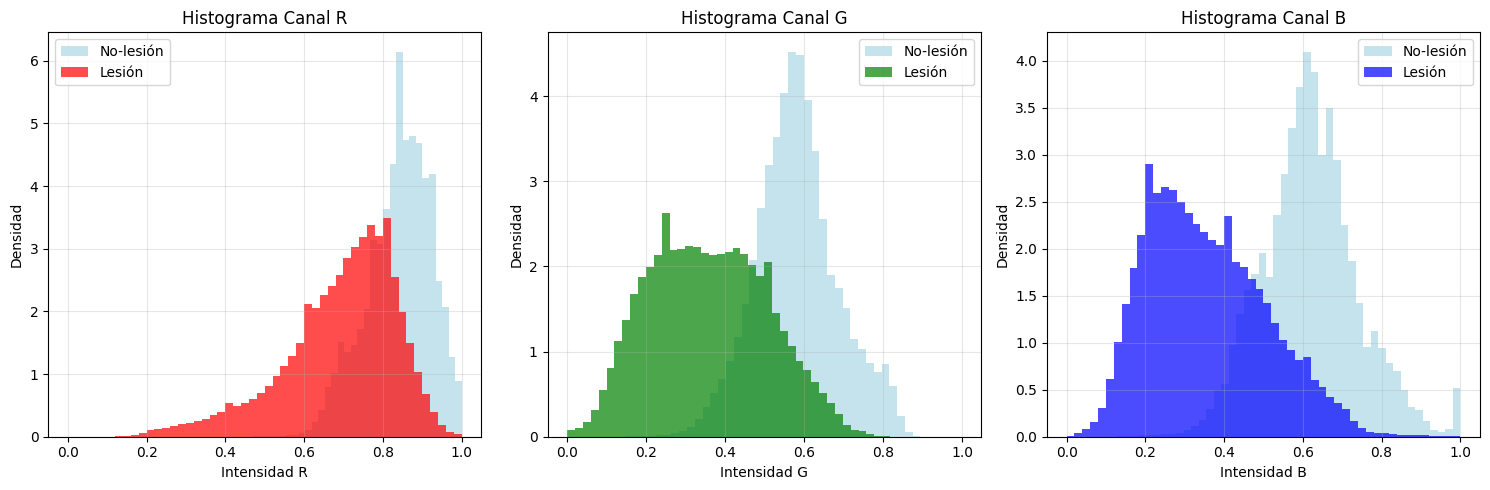


✓ Análisis de histogramas y estadísticos RGB completado


In [4]:
# ================================
# HISTOGRAMAS Y ESTADÍSTICOS RGB
# ================================

def analizar_canales_rgb(imagenes, mascaras):
    """Extrae píxeles de lesión y no-lesión para análisis"""
    lesion_pixels = []
    no_lesion_pixels = []
    
    for img, mask in zip(imagenes, mascaras):
        lesion_coords = np.where(mask == 1)
        no_lesion_coords = np.where(mask == 0)
        
        lesion_rgb = img[lesion_coords]
        no_lesion_rgb = img[no_lesion_coords]
        
        lesion_pixels.extend(lesion_rgb)
        no_lesion_pixels.extend(no_lesion_rgb)
    
    return np.array(lesion_pixels), np.array(no_lesion_pixels)

# Extraer píxeles de entrenamiento
lesion_pixels, no_lesion_pixels = analizar_canales_rgb(train_images, train_masks)

print(f"\nPíxeles extraídos:")
print(f"Lesión: {len(lesion_pixels):,}")
print(f"No-lesión: {len(no_lesion_pixels):,}")

# Estadísticos por canal
canales = ['R', 'G', 'B']
print(f"\nEstadísticos por canal:")
print("-" * 60)

for i, canal in enumerate(canales):
    lesion_canal = lesion_pixels[:, i]
    no_lesion_canal = no_lesion_pixels[:, i]
    
    print(f"\nCanal {canal}:")
    print(f"  Lesión    - Media: {np.mean(lesion_canal):.4f}, Std: {np.std(lesion_canal):.4f}")
    print(f"  No-lesión - Media: {np.mean(no_lesion_canal):.4f}, Std: {np.std(no_lesion_canal):.4f}")

# Histogramas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['red', 'green', 'blue']

for i, (canal, color) in enumerate(zip(canales, colors)):
    lesion_canal = lesion_pixels[:, i]
    no_lesion_canal = no_lesion_pixels[:, i]
    
    axes[i].hist(no_lesion_canal, bins=50, alpha=0.7, label='No-lesión', color='lightblue', density=True)
    axes[i].hist(lesion_canal, bins=50, alpha=0.7, label='Lesión', color=color, density=True)
    axes[i].set_title(f'Histograma Canal {canal}')
    axes[i].set_xlabel(f'Intensidad {canal}')
    axes[i].set_ylabel('Densidad')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Análisis de histogramas y estadísticos RGB completado")


Parámetros estimados (Bayesiano):
Lesión -> media: [0.68600243 0.3573877  0.35516417] 
Covarianza:
 [[0.0205518  0.0157023  0.01481165]
 [0.0157023  0.02190429 0.02078633]
 [0.01481165 0.02078633 0.02258838]]
No-lesión -> media: [0.92721057 0.5876107  0.6393529 ] 
Covarianza:
 [[0.00649546 0.00386727 0.00398837]
 [0.00386727 0.01081989 0.0113212 ]
 [0.00398837 0.0113212  0.0148148 ]]


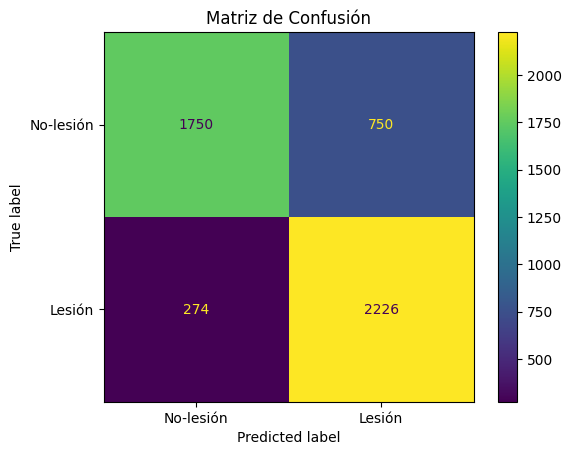


Resultados en VALIDACIÓN:
Accuracy: 0.7952
Precision: 0.7479838709677419

Reporte de clasificación:
               precision    recall  f1-score   support

   No-lesión       0.86      0.70      0.77      2500
      Lesión       0.75      0.89      0.81      2500

    accuracy                           0.80      5000
   macro avg       0.81      0.80      0.79      5000
weighted avg       0.81      0.80      0.79      5000



In [5]:
# ================================
# MODELO BAYESIANO MULTIVARIADO
# ================================

# Calcular medias y covarianzas de cada clase
mu_lesion = np.mean(lesion_pixels, axis=0)
cov_lesion = np.cov(lesion_pixels, rowvar=False)

mu_no_lesion = np.mean(no_lesion_pixels, axis=0)
cov_no_lesion = np.cov(no_lesion_pixels, rowvar=False)

print("\nParámetros estimados (Bayesiano):")
print("Lesión -> media:", mu_lesion, "\nCovarianza:\n", cov_lesion)
print("No-lesión -> media:", mu_no_lesion, "\nCovarianza:\n", cov_no_lesion)

# Definir distribuciones gaussianas
dist_lesion = multivariate_normal(mean=mu_lesion, cov=cov_lesion)
dist_no_lesion = multivariate_normal(mean=mu_no_lesion, cov=cov_no_lesion)

# ================================
# CLASIFICADOR BAYESIANO
# ================================
# Umbral = 1.0 (criterio: equiprobabilidad)
# Justificación: Cuando p(lesión|RGB) = p(no-lesión|RGB), la razón = 1.0
# Esto asume que ambas clases tienen igual probabilidad a priori
def clasificar_bayes(X, umbral=1.0):
    """Clasifica píxeles RGB usando razón de verosimilitud"""
    p_lesion = dist_lesion.pdf(X)
    p_no_lesion = dist_no_lesion.pdf(X)

    # Razón de verosimilitudes
    razon = p_lesion / (p_no_lesion + 1e-12)  # evitar división por 0

    # Decisión
    return (razon > umbral).astype(int)

# ================================
# EVALUACIÓN EN VALIDACIÓN
# ================================

# Clasificar datos de validación
y_pred = clasificar_bayes(X_validacion, umbral=1.0)

# Matriz de confusión
matrix_confusion= confusion_matrix(y_validacion, y_pred)
vis = ConfusionMatrixDisplay(matrix_confusion, display_labels=["No-lesión", "Lesión"])
vis.plot()
plt.title("Matriz de Confusión")
plt.show()


# Evaluación
print("\nResultados en VALIDACIÓN:")
print("Accuracy:", accuracy_score(y_validacion, y_pred))
print("Precision:", precision_score(y_validacion, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_validacion, y_pred, target_names=["No-lesión", "Lesión"]))

### ==========================================
## CLASIFICADOR BAYESIANO + PCA

#### Reducción de dimensionalidad con PCA
- Aplicamos PCA a los datos de entrenamiento para reducir la dimensionalidad de 3 características (RGB) a un número menor.

- Usamos PCA() de scikit-learn, que calcula automáticamente todas las componentes principales.

#### Selección de componentes principales
- Calculamos la varianza acumulada explicada por las componentes.
- Seleccionamos el número de componentes que explican al menos el 95% de la varianza.
- Justificamos esta selección basándonos en que conserva la mayor parte de la información mientras reduce la dimensionalidad.

In [6]:
# ================================
# CLASIFICADOR BAYESIANO + PCA
# ================================

from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc

# Aplicar PCA solo a los datos de entrenamiento (evitar leakage)
print("\nAplicando PCA a los datos...")
pca = PCA()
X_entrenamiento_pca = pca.fit_transform(X_entrenamiento)

# Calcular varianza acumulada
varianza_acumulada = np.cumsum(pca.explained_variance_ratio_)

# Seleccionar número de componentes que explican al menos el 95% de varianza
n_componentes = np.argmax(varianza_acumulada >= 0.95) + 1
print(f"Número de componentes seleccionados: {n_componentes}")
print(f"Varianza explicada: {varianza_acumulada[n_componentes-1]:.4f}")

# Justificación de la selección
print("\nJustificación: Se seleccionaron", n_componentes, 
      "componentes principales que explican el",
      f"{varianza_acumulada[n_componentes-1]*100:.2f}% de la varianza.")
print("Esto permite reducir la dimensionalidad manteniendo la mayor parte de la información.")



Aplicando PCA a los datos...
Número de componentes seleccionados: 2
Varianza explicada: 0.9839

Justificación: Se seleccionaron 2 componentes principales que explican el 98.39% de la varianza.
Esto permite reducir la dimensionalidad manteniendo la mayor parte de la información.


#### Clasificador bayesiano en espacio PCA
- Reentrenamos las distribuciones Gaussianas para lesión y no-lesión en el espacio reducido de PCA.
- Implementamos un clasificador similar al anterior pero trabajando en el espacio de características reducido.

In [7]:

# Reentrenar PCA con el número de componentes seleccionado
pca = PCA(n_components=n_componentes)
X_entrenamiento_pca = pca.fit_transform(X_entrenamiento)
X_validacion_pca = pca.transform(X_validacion)

# Separar píxeles por clase en el espacio PCA
lesion_pixels_pca = X_entrenamiento_pca[y_entrenamiento == 1]
no_lesion_pixels_pca = X_entrenamiento_pca[y_entrenamiento == 0]

# Calcular medias y covarianzas de cada clase en el espacio PCA
mu_lesion_pca = np.mean(lesion_pixels_pca, axis=0)
cov_lesion_pca = np.cov(lesion_pixels_pca, rowvar=False)

mu_no_lesion_pca = np.mean(no_lesion_pixels_pca, axis=0)
cov_no_lesion_pca = np.cov(no_lesion_pixels_pca, rowvar=False)

print("\nParámetros estimados (Bayesiano + PCA):")
print("Lesión -> media:", mu_lesion_pca, "\nCovarianza:\n", cov_lesion_pca)
print("No-lesión -> media:", mu_no_lesion_pca, "\nCovarianza:\n", cov_no_lesion_pca)

# Definir distribuciones gaussianas en espacio PCA
dist_lesion_pca = multivariate_normal(mean=mu_lesion_pca, cov=cov_lesion_pca, allow_singular=True)
dist_no_lesion_pca = multivariate_normal(mean=mu_no_lesion_pca, cov=cov_no_lesion_pca, allow_singular=True)

# Clasificador bayesiano en espacio PCA
def clasificar_bayes_pca(X_pca, umbral=1.0):
    """Clasifica píxeles en espacio PCA usando razón de verosimilitud"""
    p_lesion = dist_lesion_pca.pdf(X_pca)
    p_no_lesion = dist_no_lesion_pca.pdf(X_pca)

    # Razón de verosimilitudes
    razon = p_lesion / (p_no_lesion + 1e-12)  # evitar división por 0

    # Decisión
    return (razon > umbral).astype(int)



Parámetros estimados (Bayesiano + PCA):
Lesión -> media: [-0.1882128   0.00605488] 
Covarianza:
 [[0.05803362 0.00558159]
 [0.00558159 0.00835287]]
No-lesión -> media: [ 0.18821637 -0.00604884] 
Covarianza:
 [[ 0.0254087  -0.00331028]
 [-0.00331028  0.00535045]]


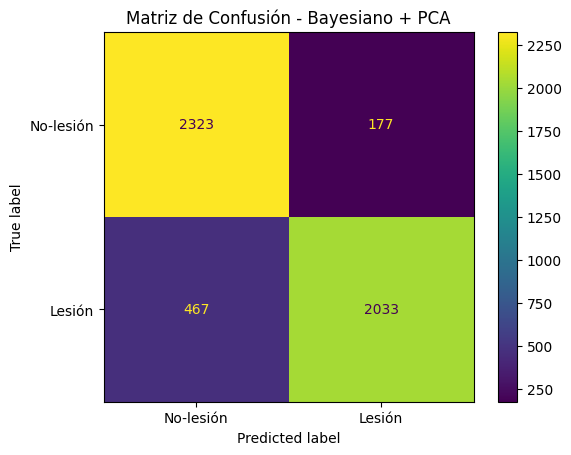


Resultados en VALIDACIÓN (Bayesiano + PCA):
Accuracy: 0.8712
Precision: 0.9199095022624434

Reporte de clasificación:
               precision    recall  f1-score   support

   No-lesión       0.83      0.93      0.88      2500
      Lesión       0.92      0.81      0.86      2500

    accuracy                           0.87      5000
   macro avg       0.88      0.87      0.87      5000
weighted avg       0.88      0.87      0.87      5000


COMPARACIÓN CON CLASIFICADOR RGB COMPLETO:
Accuracy RGB: 0.7952 vs Accuracy PCA: 0.8712


In [8]:

# Evaluar clasificador PCA en validación
y_pred_pca = clasificar_bayes_pca(X_validacion_pca, umbral=1.0)

# Matriz de confusión para PCA
matrix_confusion_pca = confusion_matrix(y_validacion, y_pred_pca)
vis_pca = ConfusionMatrixDisplay(matrix_confusion_pca, display_labels=["No-lesión", "Lesión"])
vis_pca.plot()
plt.title("Matriz de Confusión - Bayesiano + PCA")
plt.show()

# Evaluación
print("\nResultados en VALIDACIÓN (Bayesiano + PCA):")
print("Accuracy:", accuracy_score(y_validacion, y_pred_pca))
print("Precision:", precision_score(y_validacion, y_pred_pca))
print("\nReporte de clasificación:\n", classification_report(y_validacion, y_pred_pca, target_names=["No-lesión", "Lesión"]))

# Comparación con el clasificador sin PCA
print("\nCOMPARACIÓN CON CLASIFICADOR RGB COMPLETO:")
print("Accuracy RGB: {:.4f} vs Accuracy PCA: {:.4f}".format(
    accuracy_score(y_validacion, y_pred), 
    accuracy_score(y_validacion, y_pred_pca)))

#### Evaluación y comparación
- Evaluamos el clasificador PCA en el conjunto de validación.
- Comparamos los resultados con el clasificador que usa todas las características RGB.

##### Número de componentes seleccionados:

- Si el número es 2 o 3, significa que la mayor parte de la información está contenida en pocas componentes.
- Si es mayor, indica que los datos tienen una estructura más compleja.

##### Varianza explicada:
- Debe ser cercana al 95% (nuestro criterio de selección).
- Un valor más bajo indicaría que estamos perdiendo información importante.


##### Comparación de rendimiento:
- Si el accuracy con PCA es similar o mejor que con RGB completo, PCA está funcionando bien.
- Si es significativamente peor, podría indicar que estamos perdiendo información importante.

##### Matriz de confusión:
- Nos muestra cómo se distribuyen los aciertos y errores entre clases.
- Idealmente, queremos valores altos en la diagonal principal.

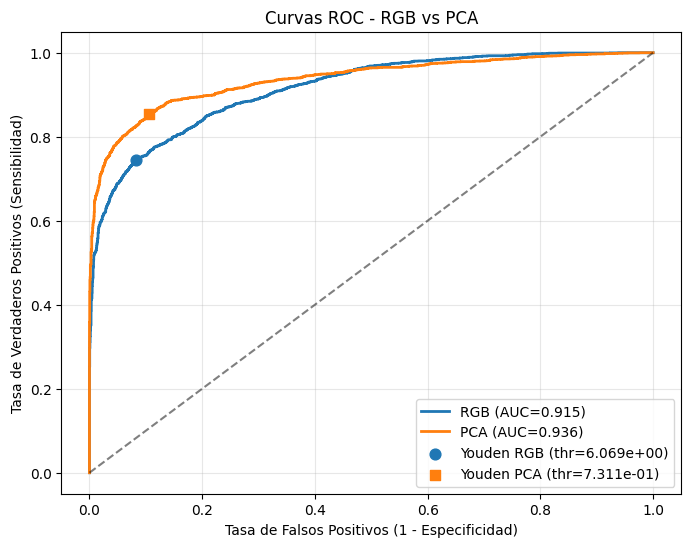


PUNTO DE OPERACIÓN (Youden J óptimo):
RGB - AUC: 0.9146, Youden thr: 6.068508e+00, TPR: 0.7452, FPR: 0.0820
PCA - AUC: 0.9365, Youden thr: 7.311075e-01, TPR: 0.8544, FPR: 0.1060

Justificación del criterio elegido: Índice de Youden (J)
Youden maximiza (TPR - FPR), eligiendo un punto que balancea sensibilidad y especificidad.
Es simple de explicar y apropiado cuando se desea buen compromiso entre ambos errores.


In [9]:
# ================================
# CURVAS ROC Y PUNTO DE OPERACIÓN (Youden J óptimo)
# ================================

# Scores (razón de verosimilitud) para validación
scores_rgb = dist_lesion.pdf(X_validacion) / (dist_no_lesion.pdf(X_validacion) + 1e-12)
scores_pca = dist_lesion_pca.pdf(X_validacion_pca) / (dist_no_lesion_pca.pdf(X_validacion_pca) + 1e-12)

# ROC para RGB
fpr_r, tpr_r, thr_r = roc_curve(y_validacion, scores_rgb)
auc_r = auc(fpr_r, tpr_r)
youden_idx_r = np.argmax(tpr_r - fpr_r)
youden_thr_r = thr_r[youden_idx_r]
youden_tpr_r = tpr_r[youden_idx_r]
youden_fpr_r = fpr_r[youden_idx_r]

# ROC para PCA
fpr_p, tpr_p, thr_p = roc_curve(y_validacion, scores_pca)
auc_p = auc(fpr_p, tpr_p)
youden_idx_p = np.argmax(tpr_p - fpr_p)
youden_thr_p = thr_p[youden_idx_p]
youden_tpr_p = tpr_p[youden_idx_p]
youden_fpr_p = fpr_p[youden_idx_p]

# Plots
plt.figure(figsize=(8,6))
plt.plot(fpr_r, tpr_r, label=f'RGB (AUC={auc_r:.3f})', lw=2)
plt.plot(fpr_p, tpr_p, label=f'PCA (AUC={auc_p:.3f})', lw=2)
plt.scatter([youden_fpr_r], [youden_tpr_r], c='C0', s=60, marker='o', label=f'Youden RGB (thr={youden_thr_r:.3e})')
plt.scatter([youden_fpr_p], [youden_tpr_p], c='C1', s=60, marker='s', label=f'Youden PCA (thr={youden_thr_p:.3e})')
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Curvas ROC - RGB vs PCA')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Imprimir resumen de puntos de operación (Youden J)
print('\nPUNTO DE OPERACIÓN (Youden J óptimo):')
print(f'RGB - AUC: {auc_r:.4f}, Youden thr: {youden_thr_r:.6e}, TPR: {youden_tpr_r:.4f}, FPR: {youden_fpr_r:.4f}')
print(f'PCA - AUC: {auc_p:.4f}, Youden thr: {youden_thr_p:.6e}, TPR: {youden_tpr_p:.4f}, FPR: {youden_fpr_p:.4f}')

# Justificación breve:
print('\nJustificación del criterio elegido: Índice de Youden (J)') 
print('Youden maximiza (TPR - FPR), eligiendo un punto que balancea sensibilidad y especificidad.') 
print('Es simple de explicar y apropiado cuando se desea buen compromiso entre ambos errores.')